In [1]:
from attention_rollout import attention_rollout, show_attention
from vision_transformer import vit_b_16

import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import wordnet as wn

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose, CenterCrop,\
    Normalize

/home/tommaso/miniconda3/envs/saint_env/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
BATCH_SIZE = 8
SEED = 3

g = torch.Generator()

# load the ImageNet validation split
dataset = ImageFolder(
    '../growingnet/datasets/ILSVRC/Data/CLS-LOC/val_folders',
    transform=Compose([ # pre-processing required by the pre-trained ViT
        Resize(256),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,
    generator=g.manual_seed(SEED))

g_vis = torch.Generator()

vis_dataset = ImageFolder(
    '../growingnet/datasets/ILSVRC/Data/CLS-LOC/val_folders',
    transform=Compose([ # pre-processing for visualization
        Resize(256),
        CenterCrop(224),
        ToTensor()
    ])
)
vis_dataloader = DataLoader(vis_dataset, batch_size=BATCH_SIZE, shuffle=True,
    generator=g_vis.manual_seed(SEED))

In [3]:
# load the pre-trained ViT
device = torch.device('cuda:0')
model = vit_b_16(weights='IMAGENET1K_SWAG_LINEAR_V1').to(device)

In [4]:
x, y = next(iter(dataloader))
x_vis, _ = next(iter(vis_dataloader))

# predict classes
p = model(x.to(device))
y_prime = p.argmax(dim=-1)

# retrieve attention matrices
As = []
for layer in model.encoder.layers:
    As.append(layer.attn_output_weights.detach())

In [5]:
# rollout attention
cls_rollout = attention_rollout(As)[:,0,1:] # classification head to patches
cls_rollout = F.upsample(cls_rollout.view(-1, 1, 14, 14), (224, 224),
    mode='bicubic') # upsample to original image size

/home/tommaso/miniconda3/envs/saint_env/lib/python3.8/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


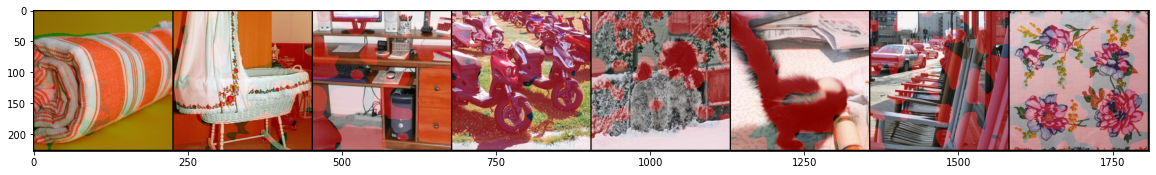

['bath_towel', 'cradle', 'desktop_computer', 'motor_scooter', 'standard_poodle', 'skunk', 'crutch', 'handkerchief']


In [6]:
# show results
show_attention(x_vis, cls_rollout, figsize=(20, 20))
print([wn.synset_from_pos_and_offset('n',
    int(dataset.classes[i][1:])).lemma_names()[0] for i in y_prime])